# TM10007 Assignment template

In [ ]:
# Run this to use from colab environment
# !pip install -q --upgrade git+https://github.com/jveenland/tm10007_ml.git

# Importing packages

In [ ]:
# General packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets as ds
import seaborn

# Classifiers
from sklearn import model_selection
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

# Scoring methods
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report

# Preprocessing steps
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from scipy.stats import shapiro
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

# Feature selection
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn import decomposition

# Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [ ]:
## Data loading functions. Uncomment the one you want to use
from worclipo.load_data import load_data

data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')





The number of samples: 115
The number of columns: 494


## Creating a split in the data

A training and test set are created. The training set will be used to fit the classifier, while the test set is remained untouched until it is used for testing the trained classifier.

Split is stratified so labels are present in both sets in same proportions.

In [ ]:
# Extract columns with labels
Y = data.pop('label').replace({'lipoma':0, 'liposarcoma':1}) #moeten we misschien nog ook de ID poppen?
print(f'The proportion of the labels is: {sum(Y)/len(Y)}')

# Extract the rest of the data (without the labels)
X = data
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.2, stratify=Y)

print(f'Size of training set: {X_train.shape}')
print(f'Size of test set: {X_test.shape}')

The proportion of the labels is: 0.5043478260869565
Size of training set: (92, 493)
Size of test set: (23, 493)


## Inspecting distribution of features
To determine data distribution of train set

### Visually inspect distribution of features

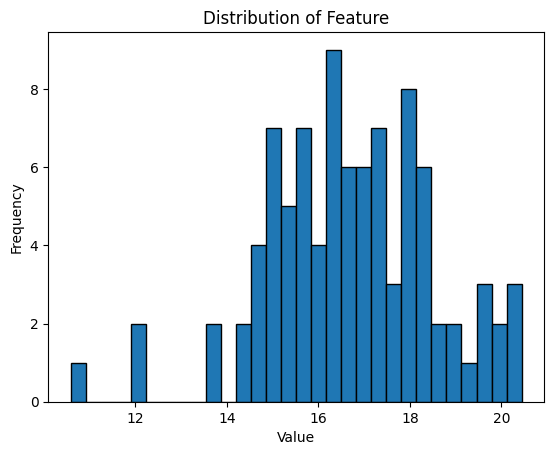

In [ ]:
## UITEINDELIJK WEGHALEN DIT!!

#Check if Gaussian distribution per column
# if Gaussian distribution, take mean for filling empty cells (later in script)
# if not Gaussion distribution (and outliers or skewed), take median for filling empty cells (later in script)

# plt.hist(X_train.iloc[:, 15], bins=30, edgecolor='k') # Change number of colum to see distribution (between width dataframe)
plt.hist(X_train['PREDICT_original_tf_Gabor_entropy_F0.2_A1.57'], bins=30, edgecolor='k') # Change number of colum to see distribution (between width dataframe)


plt.title('Distribution of Feature')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

# print(X_train.head())

## Preprocessing Data

### Missing Values
Determining cells with missing values and filling these

In [ ]:
# Filling missing values with correct value based on type of distribution per column

# Definieer alpha voor de significantietest BEARGUMENTEREN WAAROM DEZE TEST IN REPORT + WAARDE
alpha = 0.05

# Initialiseer een teller voor normaal verdeelde kolommen
normal_distributed_columns_count = 0
not_normal_distributed_columns_count = 0
nans_found_in_column_count = 0

# Loop door elke kolom in de DataFrame en voer Shapiro-Wilk test uit
for column in X_train:
    stat, p = shapiro(X_train[column])
    if p > alpha:
        # print(column)
        normal_distributed_columns_count += 1  # Tel kolom als normaal verdeeld
        if X_train[column].isna().sum() > 0:
            X_train[column].fillna(X_train[column].mean)
            nans_found_in_column_count += 1
    else:
        not_normal_distributed_columns_count += 1  # Tel kolom als normaal verdeeld
        if X_train[column].isna().sum() > 0:
            X_train[column].fillna(X_train[column].median)
            nans_found_in_column_count += 1

print(f'The number of normal distributed columns is: {normal_distributed_columns_count}')
print(f'The number of not normal distributed columns is: {not_normal_distributed_columns_count}')
print(f'The number of columns where nans were filled: {nans_found_in_column_count}')

The number of normal distributed columns is: 89
The number of not normal distributed columns is: 404
The number of columns where nans were filled: 0


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1879: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


### Feature Scaling
Scale features in Train set

#### Motivation of chosen scaler

In [ ]:
# Define counter for columns with many outliers
columns_with_many_outliers_count = 0

for column in X_train:
    Q1 = X_train[column].quantile(0.25)
    Q3 = X_train[column].quantile(0.75)
    IQR = Q3 - Q1

    # Calculate number of outliers
    outliers = X_train[(X_train[column] < (Q1 - 1.5 * IQR)) | (X_train[column] > (Q3 + 1.5 * IQR))]
    outliers_count = outliers.shape[0]

    # Define what 'many' outliers mean
    if outliers_count > 0.05 * X_train.shape[0]:
        columns_with_many_outliers_count += 1
        # print(f"{column} has many outliers: {outliers_count} outliers")

print(f"Number of columns with many outliers: {columns_with_many_outliers_count}/{len(X_train.columns)}")


Number of columns with many outliers: 201/493


#### Scaling the data

In [ ]:
# Initialize a RobustScaler object
scaler = RobustScaler()

# Fit the scaler on the training data
scaler.fit(X_train)

# Transform both training and testing data using the scaler
X_train_sc = (scaler.transform(X_train))
X_test_sc = scaler.transform(X_test)

X_train_sc = pd.DataFrame(X_train_sc)
X_test_sc = pd.DataFrame(X_test_sc)

# Inspecting data

### Feature selection and extraction

In [ ]:
# Zero variance
selector = VarianceThreshold(threshold=0)
vs_fit = selector.fit(X_train_sc)

X_train_zv = vs_fit.transform(X_train_sc)
X_test_zv = vs_fit.transform(X_test_sc)

# Willen we dit nou van train of test set weten?
print(f'Amount of features with zero variance: {X_train_sc.shape[1]-X_train_zv.shape[1]}')
print(f'Amount of features after removing features with zero variance: {X_train_zv.shape[1]}')

Amount of features with zero variance: 19
Amount of features after removing features with zero variance: 474


In [ ]:
# Feature selection using K best - chi squared test
fs_chi = SelectKBest(f_classif, k=5).fit(X_train_zv, Y_train)

X_train_fs = fs_chi.transform(X_train_zv)
X_test_fs = fs_chi.transform(X_test_zv)

print(X_train_fs.shape)
print(X_test_fs.shape)


(92, 5)
(23, 5)


In [ ]:
# # PCA
# # If there are more samples than features left after RFECV then perform PCA
# pca = decomposition.PCA(n_components=0.95)
# pca.fit(X_train_zv)
# X_train_fs = pca.transform(X_train_zv)
# X_test_fs = pca.transform(X_test_zv)

# Classifiers

### KNN

In [ ]:
# Define cv and knn classifier
cv_knn = 6
knn_model = KNeighborsClassifier()

# Define range for n neighbours to be max the size of one split
max_n_neighbors = len(X_train_fs) // cv_knn - 1
print("Max number of neighbors:", max_n_neighbors)

# Define the parameter grid
param_grid_knn = {
    'n_neighbors': list(range(1, max_n_neighbors, 2)),
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # p=1 for Manhattan distance, p=2 for Euclidean distance
}

# Create the grid search object with ROC AUC scoring
grid_search_knn = GridSearchCV(knn_model, param_grid_knn, cv=cv_knn, scoring='roc_auc')

# Fit the grid search to the data
grid_search_knn.fit(X_train_fs, Y_train)

# Print the best parameters
print("Best parameters found: ", grid_search_knn.best_params_)

# Get the best estimator
best_knn_model = grid_search_knn.best_estimator_
print(f'Best estimator: {best_knn_model}')

# See how well model works on train data:
pred_knn_train = best_knn_model.predict(X_train_fs)
pred_proba_knn_train = best_knn_model.predict_proba(X_train_fs)[:,1]

roc_auc_knn_train = roc_auc_score(Y_train, pred_proba_knn_train)
print('ROC AUC train =', roc_auc_knn_train)
accuracy_knn_train = accuracy_score(Y_train, pred_knn_train)
print('Accuracy train =', accuracy_knn_train)

# See how well model works on test data:
pred_knn_test = best_knn_model.predict(X_test_fs)
pred_proba_knn_test = best_knn_model.predict_proba(X_test_fs)[:,1]

roc_auc_knn_test = roc_auc_score(Y_test, pred_proba_knn_test)
print('ROC AUC test =', roc_auc_knn_test)
accuracy_knn_test = accuracy_score(Y_test, pred_knn_test)
print('Accuracy test =', accuracy_knn_test)

Best parameters found:  {'n_neighbors': 5, 'p': 2, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(weights='distance')
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        46
           1       1.00      1.00      1.00        46

    accuracy                           1.00        92
   macro avg       1.00      1.00      1.00        92
weighted avg       1.00      1.00      1.00        92

ROC AUC = 1.0
Accuracy = 1.0
              precision    recall  f1-score   support

           0       0.64      0.64      0.64        11
           1       0.67      0.67      0.67        12

    accuracy                           0.65        23
   macro avg       0.65      0.65      0.65        23
weighted avg       0.65      0.65      0.65        23

ROC AUC = 0.6515151515151515
Accuracy = 0.6521739130434783


### Random forest

In [ ]:
# Visualise the effect of n_estimators
roc_auc_scores = []

for k in range(1, 100):
    rf_model = RandomForestClassifier(n_estimators=k)
    rf_model.fit(X_train_fs, Y_train)

    pred_proba_RF_test =rf_model.predict_proba(X_test_fs)[:,1]
    roc_auc_RF_test = roc_auc_score(Y_test, pred_proba_RF_test)
    roc_auc_scores.append(roc_auc_RF_test)

# Plot the relationship between K and testing roc auc
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(1, 2, 1)
plt.plot(range(1, 100), roc_auc_scores)
plt.xlabel('Value of n_estimators for Random Forest Classifier')
plt.ylabel('ROC AUC')

# Find the index of the (first) maximum ROC AUC score
max_roc_auc_index = np.argmax(roc_auc_scores)

# Find the maximum ROC AUC score and its corresponding n_estimators
max_roc_auc = roc_auc_scores[max_roc_auc_index]
best_n_estimators_roc_auc = max_roc_auc_index + 1  # Adding 1 to convert index to n_estimators value

# Print the results
print("Maximum ROC AUC:", max_roc_auc, "at n_estimators =", best_n_estimators_roc_auc)

# The model shows there is a lot of variety in which estimator is best
# But since it is best to use a more simple model (with the same results)
# We choose n_estimators = 15

# Define cv and RF classifier
cv_RF = 7
RF_model = RandomForestClassifier(n_estimators=15)

# Define the parameter grid
param_grid_RF = {
    'bootstrap': [True, False],
    'min_samples_leaf': list(range(1, 7, 2))
}

# Create the grid search object with ROC AUC scoring
grid_search_RF = GridSearchCV(RF_model, param_grid_RF, cv=cv_RF, scoring='roc_auc', error_score='raise')

# Fit the grid search to the data
grid_search_RF.fit(X_train_fs, Y_train)

# Print the best parameters
print("Best parameters found: ", grid_search_RF.best_params_)

# Get the best estimator
best_RF_model = grid_search_RF.best_estimator_
print(best_RF_model)

# See how well model works on train data:
pred_RF_train = best_RF_model.predict(X_train_fs)
pred_proba_RF_train = best_RF_model.predict_proba(X_train_fs)[:,1]

roc_auc_RF_train = roc_auc_score(Y_train, pred_proba_RF_train)
print('ROC AUC train=', roc_auc_RF_train)
accuracy_RF_train = accuracy_score(Y_train, pred_RF_train)
print('Accuracy train=', accuracy_RF_train)

# See how well model works on test data:
pred_RF_test = best_RF_model.predict(X_test_fs)
pred_proba_RF_test = best_RF_model.predict_proba(X_test_fs)[:,1]

roc_auc_RF_test = roc_auc_score(Y_test, pred_proba_RF_test)
print('ROC AUC test=', roc_auc_RF_test)
accuracy_RF_test = accuracy_score(Y_test, pred_RF_test)
print('Accuracy test=', accuracy_RF_test)

Best parameters found:  {'bootstrap': True, 'min_samples_leaf': 3}
RandomForestClassifier(min_samples_leaf=3)
              precision    recall  f1-score   support

           0       0.91      0.91      0.91        46
           1       0.91      0.91      0.91        46

    accuracy                           0.91        92
   macro avg       0.91      0.91      0.91        92
weighted avg       0.91      0.91      0.91        92

ROC AUC = 0.9130434782608697
Accuracy = 0.9130434782608695
              precision    recall  f1-score   support

           0       0.73      0.73      0.73        11
           1       0.75      0.75      0.75        12

    accuracy                           0.74        23
   macro avg       0.74      0.74      0.74        23
weighted avg       0.74      0.74      0.74        23

ROC AUC = 0.7386363636363636
Accuracy = 0.7391304347826086


### Support Vector Machine

In [ ]:
# Define cv and SVM classifier
cv_svm = 5
svm_model = svm.SVC(probability=True)

# Define the parameter grid for SVM
param_grid_svm = {
    'C': [0.001, 0.01, 0.1, 1, 10],  # Regularization parameter
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],  # Kernel coefficient
    'kernel': ['rbf', 'linear', 'poly'] # Kernel type
}

# Create the grid search object with ROC AUC scoring
grid_search_svm = GridSearchCV(svm_model, param_grid_svm, cv=cv_svm, scoring='roc_auc', error_score='raise')

# Fit the grid search to the data
grid_search_svm.fit(X_train_fs, Y_train)

# Print the best parameters
print("Best parameters found: ", grid_search_svm.best_params_)

# Get the best estimator
best_svm_model = grid_search_svm.best_estimator_
print(best_svm_model)

# See how well model works on train data
pred_svm_train = best_svm_model.predict(X_train_fs)
pred_proba_svm_train = best_svm_model.decision_function(X_train_fs)

roc_auc_svm_train = roc_auc_score(Y_train, pred_proba_svm_train)
print('ROC AUC train=', roc_auc_svm_train)
accuracy_svm_train = accuracy_score(Y_train, pred_svm_train)
print('Accuracy train=', accuracy_svm_train)

# See how well model works on test data
pred_svm_test = best_svm_model.predict(X_test_fs)
pred_proba_svm_test = best_svm_model.decision_function(X_test_fs)

roc_auc_svm_test = roc_auc_score(Y_test, pred_proba_svm_test)
print('ROC AUC test=', roc_auc_svm_test)
accuracy_svm_test = accuracy_score(Y_test, pred_svm_test)
print('Accuracy test=', accuracy_svm_test)

Best parameters found:  {'C': 1, 'gamma': 'scale'}
SVC(C=1, probability=True)
              precision    recall  f1-score   support

           0       0.76      0.85      0.80        46
           1       0.83      0.74      0.78        46

    accuracy                           0.79        92
   macro avg       0.80      0.79      0.79        92
weighted avg       0.80      0.79      0.79        92

ROC AUC = 0.7934782608695652
Accuracy = 0.7934782608695652
              precision    recall  f1-score   support

           0       0.67      0.73      0.70        11
           1       0.73      0.67      0.70        12

    accuracy                           0.70        23
   macro avg       0.70      0.70      0.70        23
weighted avg       0.70      0.70      0.70        23

ROC AUC = 0.696969696969697
Accuracy = 0.6956521739130435


# Visualisatie

## Receiver Operating Curve

In [ ]:
# Plot the ROC curve of the different classifiers
plt.figure()
lw = 2
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Curve')

# knn
fpr_knn, tpr_knn, _ = roc_curve(Y_test, pred_proba_knn_test)
roc_auc_knn = auc(fpr_knn, tpr_knn)
plt.plot(fpr_knn, tpr_knn, lw=lw, label='knn (AUC = %0.2f)' % roc_auc_knn)

# RF
fpr_RF, tpr_RF, _ = roc_curve(Y_test, pred_proba_RF_test)
roc_auc_RF = auc(fpr_RF, tpr_RF)
plt.plot(fpr_RF, tpr_RF, lw=lw, label='RF (AUC = %0.2f)' % roc_auc_RF)

# svm
fpr_svm, tpr_svm, _ = roc_curve(Y_test, pred_proba_svm_test)
roc_auc_svm = auc(fpr_svm, tpr_svm)
plt.plot(fpr_svm, tpr_svm, lw=lw, label='svm (AUC = %0.2f)' % roc_auc_svm)

plt.legend(loc="lower right")
plt.show()

## Learning curves

In [ ]:
fig = plt.figure(figsize=(15,4))

# knn
ax = fig.add_subplot(1, 3, 1)
plot_learning_curve(best_knn_model, 'KNN classifier', X_train_fs, Y_train, ax, ylim=(0.3, 1.03), cv=cv_knn)

# RF
ax = fig.add_subplot(1, 3, 2)
plot_learning_curve(best_RF_model, 'RF classifier', X_train_fs, Y_train, ax, ylim=(0.3, 1.03), cv=cv_RF)

# CVM
ax = fig.add_subplot(1, 3, 3)
plot_learning_curve(best_svm_model, 'SVM classifier', X_train_fs, Y_train, ax, ylim=(0.3, 1.03), cv=cv_svm)